CELL 1 — Imports + seeds

In [1]:
# Operating system utilities
import os

# Array handling
import numpy as np

# Pickle for loading normalization stats
import pickle

# EEG preprocessing libraries
import mne
import pywt

# Machine learning utilities
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports loaded and seeds set.")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


✅ Imports loaded and seeds set.


CELL 2 — Load trained model + normalization stats

In [2]:
# ============================================================
# EEGViT – SAFE INFERENCE SCRIPT (ALL-IN-ONE)
# ============================================================

import os
import zipfile
import tempfile
import pickle
import tensorflow as tf
from tensorflow.keras import layers, Model


# ============================================================
# PATHS
# ============================================================

MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\EEGViT model\ad_eegvit-v1.keras"
MEAN_PATH  = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\train_mean.pkl"
STD_PATH   = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\train_std.pkl"
SAFE_MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\ad_eegvit-v1_SAFE.h5"


# ============================================================
# TRANSFORMER BLOCK
# ============================================================

def transformer_block(x, dim, heads, dim_head, mlp_dim, dropout):
    # --- Self-attention (PreNorm) ---
    x_norm1 = layers.LayerNormalization()(x)
    attn = layers.MultiHeadAttention(
        num_heads=heads,
        key_dim=dim_head,
        dropout=dropout,
    )(x_norm1, x_norm1)
    attn = layers.Dense(dim)(attn)
    attn = layers.Dropout(dropout)(attn)
    x = layers.Add()([x, attn])

    # --- Feed-forward (PreNorm) ---
    x_norm2 = layers.LayerNormalization()(x)
    ff = layers.Dense(mlp_dim, activation="gelu")(x_norm2)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(dim)(ff)
    ff = layers.Dropout(dropout)(ff)
    x = layers.Add()([x, ff])

    return x


# ============================================================
# CLS TOKEN + POSITIONAL EMBEDDING
# ============================================================

class AddClassTokenAndPosEmbedding(layers.Layer):
    def __init__(self, num_patches, dim, emb_dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.dim = dim
        self.dropout = layers.Dropout(emb_dropout)

    def build(self, input_shape):
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=(1, self.num_patches + 1, self.dim),
            initializer="random_normal",
            trainable=True,
        )
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.dim),
            initializer="random_normal",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x, training=None):
        B = tf.shape(x)[0]
        cls_tokens = tf.repeat(self.cls_token, repeats=B, axis=0)
        x = tf.concat([cls_tokens, x], axis=1)
        x = x + self.pos_embedding[:, :tf.shape(x)[1], :]
        return self.dropout(x, training=training)


# ============================================================
# EEGViT MODEL (MATCHES TRAINING EXACTLY)
# ============================================================

def build_eeg_vit_keras(
    num_chan=127,
    num_time=100,
    num_patches=10,
    num_classes=1,
    dim=32,
    depth=4,
    heads=16,
    mlp_dim=64,
    dim_head=64,
    dropout=0.1,
    emb_dropout=0.1,
    pool="cls",
):

    assert num_time % num_patches == 0
    patch_len = num_time // num_patches

    inp = layers.Input(shape=(num_chan, num_time), name="eeg_input")

    # ---- Patch embedding ----
    def to_patches(t):
        B = tf.shape(t)[0]
        C = tf.shape(t)[1]
        t = tf.reshape(t, (B, C, num_patches, patch_len))
        t = tf.transpose(t, perm=[0, 2, 1, 3])
        t = tf.reshape(t, (B, num_patches, C * patch_len))
        return t

    x = layers.Lambda(to_patches, name="to_patches")(inp)
    x = layers.Dense(dim, name="patch_linear")(x)

    # ---- CLS + positional embedding ----
    x = AddClassTokenAndPosEmbedding(
        num_patches=num_patches,
        dim=dim,
        emb_dropout=emb_dropout,
        name="cls_pos_embedding"
    )(x)

    # ---- Transformer encoder ----
    for _ in range(depth):
        x = transformer_block(
            x,
            dim=dim,
            heads=heads,
            dim_head=dim_head,
            mlp_dim=mlp_dim,
            dropout=dropout,
        )

    # ---- Pooling ----
    if pool == "mean":
        x = tf.reduce_mean(x, axis=1)
    else:
        x = x[:, 0, :]

    x = layers.LayerNormalization(name="final_norm")(x)

    out = layers.Dense(1, activation="sigmoid", name="output")(x)
    return Model(inp, out, name="EEGViT")


# ============================================================
# EXTRACT WEIGHTS FROM .KERAS
# ============================================================

def extract_weights_from_keras(keras_path):
    tmp_dir = tempfile.mkdtemp(prefix="keras_weights_")
    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        weight_files = [
            n for n in names
            if n.endswith(".h5") and "weights" in n.lower()
        ]
        if not weight_files:
            raise FileNotFoundError("No weights file found inside .keras")
        z.extract(weight_files[0], tmp_dir)
        return os.path.join(tmp_dir, weight_files[0])


# ============================================================
# BUILD MODEL + LOAD WEIGHTS
# ============================================================

model = build_eeg_vit_keras()

weights_path = extract_weights_from_keras(MODEL_PATH)
model.load_weights(weights_path)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)

print("✅ EEGViT model loaded successfully.")


# ============================================================
# LOAD TRAINING MEAN / STD
# ============================================================

with open(MEAN_PATH, "rb") as f:
    train_mean = pickle.load(f)

with open(STD_PATH, "rb") as f:
    train_std = pickle.load(f)

print("✅ Training mean and std loaded.")


# ============================================================
# SAVE SAFE MODEL
# ============================================================

model.save(SAFE_MODEL_PATH)
print(f"✅ Safe EEGViT model saved to:\n{SAFE_MODEL_PATH}")


✅ EEGViT model loaded successfully.
✅ Training mean and std loaded.
✅ Safe EEGViT model saved to:
C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\ad_eegvit-v1_SAFE.h5


CELL 3 — Load ONLY excluded trials

In [3]:
# Local EEG data paths
NEG_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_negative.npy"
POS_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_positive.npy"

# Load full arrays
X_neg_full = np.load(NEG_PATH).astype(np.float32)
X_pos_full = np.load(POS_PATH).astype(np.float32)

print("✅ EEG arrays loaded.")
print("Negative shape:", X_neg_full.shape)
print("Positive shape:", X_pos_full.shape)

# Extract ONLY last 5 trials (excluded during training)
X_neg_excluded = X_neg_full[-5:]
X_pos_excluded = X_pos_full[-5:]

print("✅ Extracted excluded trials:")
print("Excluded negative:", X_neg_excluded.shape)
print("Excluded positive:", X_pos_excluded.shape)


✅ EEG arrays loaded.
Negative shape: (31, 127, 150000)
Positive shape: (46, 127, 150000)
✅ Extracted excluded trials:
Excluded negative: (5, 127, 150000)
Excluded positive: (5, 127, 150000)


CELL 4 — Select ONLY last ad_negative sample (target = 0)

In [36]:
# Select ONLY the last excluded negative trial
X_test_trial = X_neg_excluded[-5]
y_test_trial = 0  # Ground truth label

print("✅ Selected last excluded ad_negative trial.")
print("Trial shape:", X_test_trial.shape)
print("Ground truth label:", y_test_trial)


✅ Selected last excluded ad_negative trial.
Trial shape: (127, 150000)
Ground truth label: 0


* down sampling

In [37]:
# --- Downsample from 1000 Hz -> 500 Hz (keep output name: X_test_trial) ---
sfreq_in = 1000
sfreq_out = 500

X_test_trial = mne.filter.resample(
    X_test_trial.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("✅ Downsampled X_test_trial to 500 Hz.")
print("Trial shape after downsampling:", X_test_trial.shape, X_test_trial.dtype)


✅ Downsampled X_test_trial to 500 Hz.
Trial shape after downsampling: (127, 75000) float32


CELL 5 — Helper + preprocessing classes

In [38]:
# Helper to generate channel names
def _names_from_index_mapping(n_channels, index_to_name):
    return [f"EEG{i+1}" for i in range(n_channels)]

# Helper to create MNE Raw object
def _make_raw(eeg, sfreq, ch_names):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    return mne.io.RawArray(eeg, info, verbose=False)

# Wavelet ICA class
class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.ica = None

    def fit(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        self.ica = FastICA(n_components=min(self.n_components, X.shape[0]), random_state=42)
        S = self.ica.fit_transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        pywt.waverec(coeffs, self.wavelet, axis=1)

    def transform(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica.transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        return pywt.waverec(coeffs, self.wavelet, axis=1)

print("✅ Preprocessing helpers defined.")


✅ Preprocessing helpers defined.


CELL 6 — Apply preprocessing to unseen test trial

In [39]:
# Sampling frequency (same as training)
fs = 500.0

# Create Raw object
raw = _make_raw(X_test_trial, fs, _names_from_index_mapping(X_test_trial.shape[0], None))

# Notch filtering
raw.notch_filter([50, 100, 150], verbose=False)

# High-pass filtering
raw.filter(l_freq=0.05, h_freq=None, verbose=False)

# Common average reference
raw.set_eeg_reference("average", projection=True)
raw.apply_proj()

# Extract cleaned signal
X_clean = raw.get_data().astype(np.float32)

print("✅ Preprocessing applied.")
print("Cleaned trial shape:", X_clean.shape)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Preprocessing applied.
Cleaned trial shape: (127, 75000)


CELL 7 — Segment test trial

In [40]:
# Segment size
SEGMENT_SIZE = 100

# Segment the trial
segments = []
for i in range(X_clean.shape[1] // SEGMENT_SIZE):
    seg = X_clean[:, i*SEGMENT_SIZE:(i+1)*SEGMENT_SIZE]
    segments.append(seg)

# Convert to array
X_test_segments = np.array(segments, dtype=np.float32)

print("✅ Trial segmented.")
print("Segments shape:", X_test_segments.shape)


✅ Trial segmented.
Segments shape: (750, 127, 100)


CELL 8 — Reshape + normalize using TRAINING stats

In [41]:
# Add channel dimension
X_test = X_test_segments[..., np.newaxis]

# Normalize using training mean/std
X_test_norm = (X_test - train_mean) / train_std

print("✅ Normalization applied using training statistics.")
print("Final test shape:", X_test_norm.shape)


✅ Normalization applied using training statistics.
Final test shape: (750, 127, 100, 1)


CELL 9 — Run inference

In [42]:
# Predict probabilities
y_probs = model.predict(X_test_norm, verbose=0)

# Convert to binary predictions
y_preds = (y_probs >= 0.5).astype(int).flatten()

# True labels
y_true = np.zeros_like(y_preds)

print("✅ Inference completed.")
print("Predicted labels:", y_preds[:10])


✅ Inference completed.
Predicted labels: [0 1 1 0 1 0 1 0 0 1]


CELL 10 — Confusion matrix plot

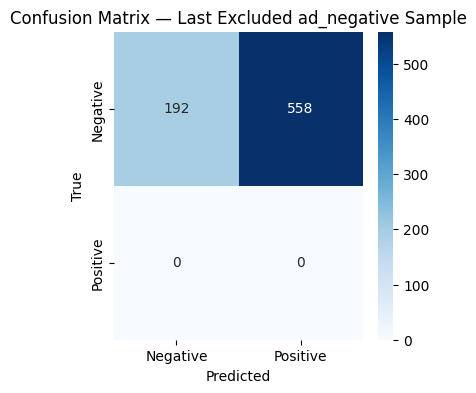

✅ Confusion matrix plotted.


In [43]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_preds)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Last Excluded ad_negative Sample")
plt.show()

print("✅ Confusion matrix plotted.")
